In [1]:
import numpy as np
import matplotlib.pylab as plt
import random
import pandas as pd

In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.distributions import normal

In [3]:
from torch.optim import lr_scheduler

# Loading data

In [4]:
Xc = np.load('./data/control_beats.npy')
Xp = np.load('./data/positive_beats.npy')

X = np.concatenate((Xc, Xp))
Y = np.zeros(len(X))

In [5]:
X.shape

(16719, 500)

In [6]:
def remap(x, out_min, out_max):
    in_min, in_max = np.min(x), np.max(x)
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [7]:
X = np.array([remap(x, -1, 1) for x in X])

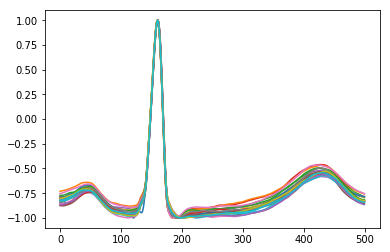

In [8]:
plt.figure()
for x in X[:20]:
    plt.plot(x)
plt.show()

In [9]:
import torch.utils.data as utils

train = torch.utils.data.TensorDataset(torch.Tensor(X), torch.Tensor(Y))
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True) 

# Neural network

In [10]:
nn_dim = 250
nn_dim2 = 125
latent_dim = 10
img_shape = len(X[0])

In [11]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(img_shape, nn_dim)
        self.fc2 = nn.Linear(nn_dim, nn_dim2)
        
        self.fc21 = nn.Linear(nn_dim2, latent_dim)
        self.fc22 = nn.Linear(nn_dim2, latent_dim)
        
        self.fc3 = nn.Linear(latent_dim, nn_dim2)
        self.fc4 = nn.Linear(nn_dim2, nn_dim)
        self.fc5 = nn.Linear(nn_dim, img_shape)

    def encode(self, x):
        h1 = F.leaky_relu(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def reparameterize_static(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return std.add_(mu)

    def decode(self, z):
        h3 = F.leaky_relu(self.fc3(z))
        h4 = F.leaky_relu(self.fc4(h3))
        return self.fc5(h4)
#         return torch.tanh(self.fc5(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, img_shape))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [12]:
def visualize(model, latent_dim, rangee):
    viz = []
    
    random_index = np.random.randint(len(X)-1)
    X_random = X[random_index]
    zi, zi_std = model.encode(torch.Tensor(X_random))
    
#     zi = torch.randn(latent_dim)
    
    for j in range(latent_dim):    
        buf = []   
        for i in rangee:
            x = zi.clone()
            x[j] += i
            zi2 = torch.zeros(latent_dim)
            gen_imgs = model.decode(model.reparameterize_static(x, zi2))
            gen_imgs_np = gen_imgs.data.numpy()
            buf.append(gen_imgs_np)
        viz.append(buf)
    
    N, M = 5, int(latent_dim / 5)
    fig, axs = plt.subplots(M, N, sharex=True, sharey=True, figsize=(int(N*3), int(M*3)))
    
    k = 0
    for i in range(M):
        for j in range(N):
            axs[i, j].plot(X_random, ls = '--', color = 'black')

            ts = np.array(viz[k]).T
            axs[i, j].plot(ts[:, 0], lw = 3, color = 'blue')
            axs[i, j].plot(ts[:, 1], lw = 3, color = 'black')
            axs[i, j].plot(ts[:, 2], lw = 3, color = 'red')
            k += 1
    plt.show()
    

def visualize_beat_reconstruction(X, model):
    I = torch.randint(len(X)-1, (1, ))
    x_input = torch.Tensor(np.array([X[I]]))
    x_vector = model.encode(x_input)
    x_reconstruct = model.decode(model.reparameterize(x_vector[0], x_vector[1]))

    plt.figure()
    plt.title('Random reconstructed beat')
    plt.plot(X[I])
    plt.plot(x_reconstruct.data.numpy()[0])
    plt.show()

# Training

In [13]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x.view(-1, img_shape), reduction='sum')
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, img_shape), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD

In [14]:
epochs = 50

beta = 100

C, C_final = 0, 25
C_stop = epochs #25
C_delta = (1 / C_stop) * C_final

In [15]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Epoch 0 | BCE 39.66358 | KL 0.009114194 | C 0 | (KL-C) * beta 0.9114193730056286 | Loss 40.575


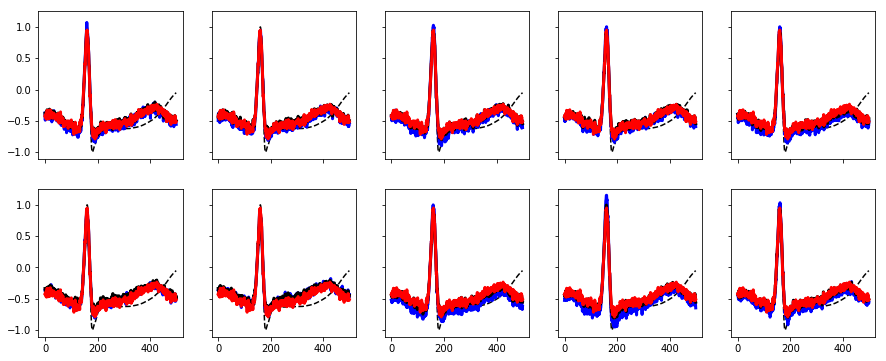

Epoch 1 | BCE 22.002373 | KL 0.52375597 | C 0.5 | (KL-C) * beta 2.375596761703491 | Loss 24.37797


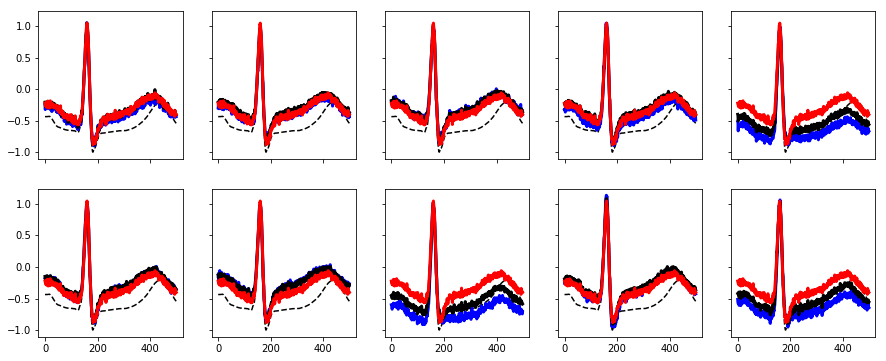

Epoch 2 | BCE 24.807793 | KL 1.0082606 | C 1.0 | (KL-C) * beta 0.8260607719421387 | Loss 25.633854


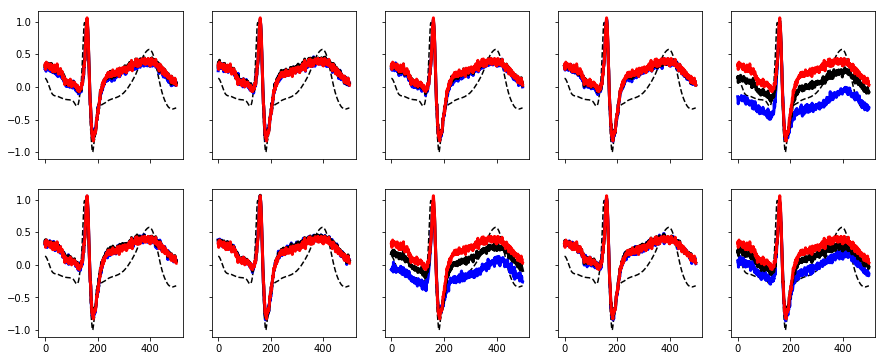

Epoch 3 | BCE 22.863007 | KL 1.3867512 | C 1.5 | (KL-C) * beta 11.324882507324219 | Loss 34.18789


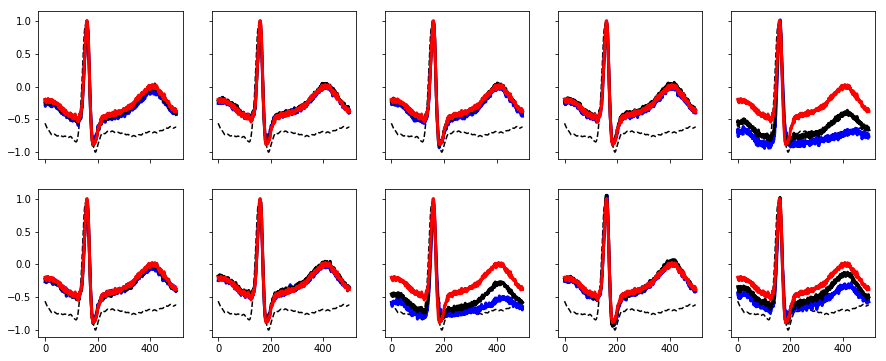

Epoch 4 | BCE 17.599712 | KL 2.3234189 | C 2.0 | (KL-C) * beta 32.341885566711426 | Loss 49.941597


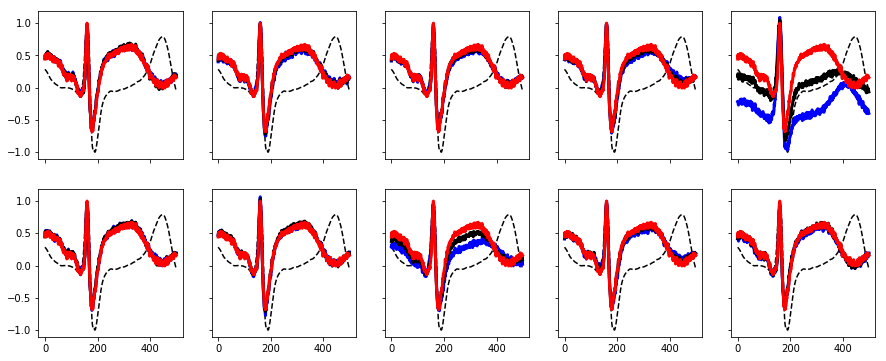

Epoch 5 | BCE 13.50563 | KL 2.6317146 | C 2.5 | (KL-C) * beta 13.17145824432373 | Loss 26.677088


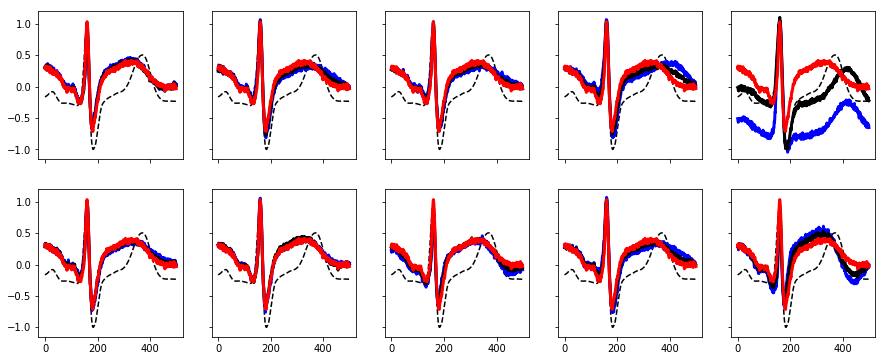

Epoch 6 | BCE 13.011572 | KL 3.0359497 | C 3.0 | (KL-C) * beta 3.594970703125 | Loss 16.606543


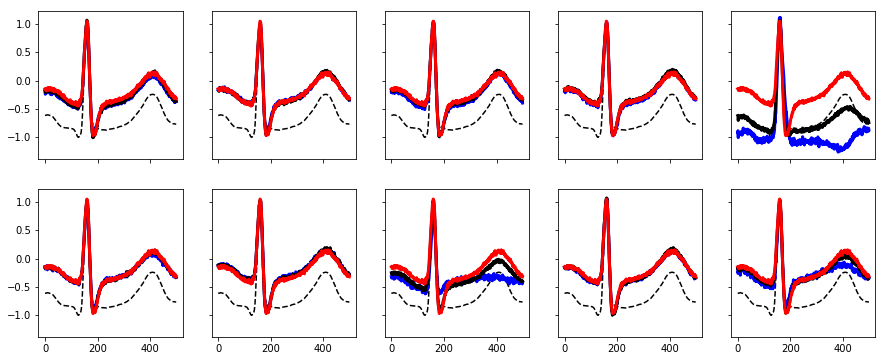

Epoch 7 | BCE 10.118801 | KL 3.7559893 | C 3.5 | (KL-C) * beta 25.598931312561035 | Loss 35.71773


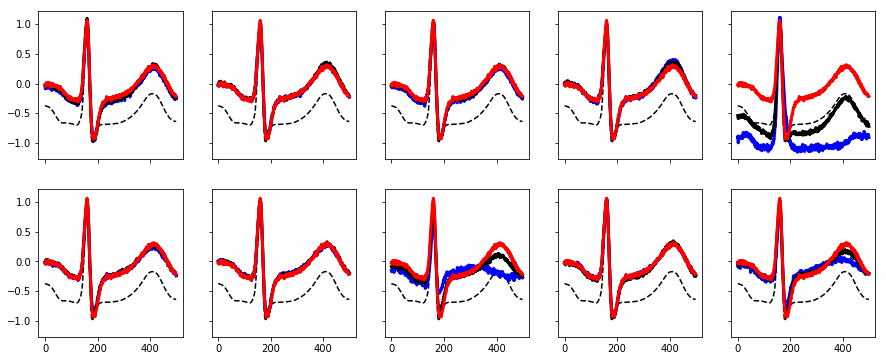

Epoch 8 | BCE 18.835886 | KL 3.8069878 | C 4.0 | (KL-C) * beta 19.301223754882812 | Loss 38.137108


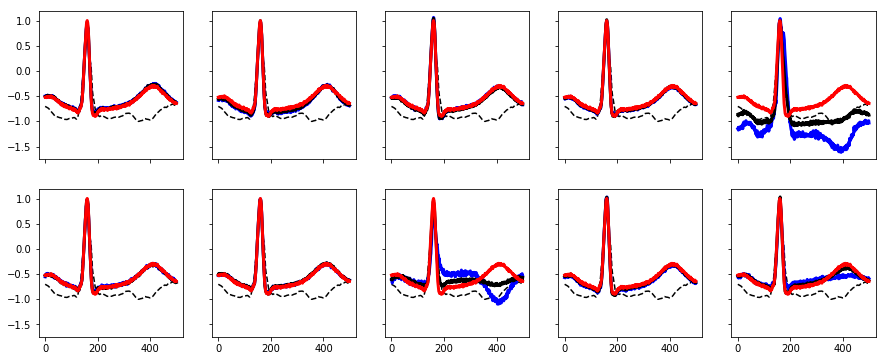

Epoch 9 | BCE 12.838271 | KL 4.318816 | C 4.5 | (KL-C) * beta 18.11838150024414 | Loss 30.956654


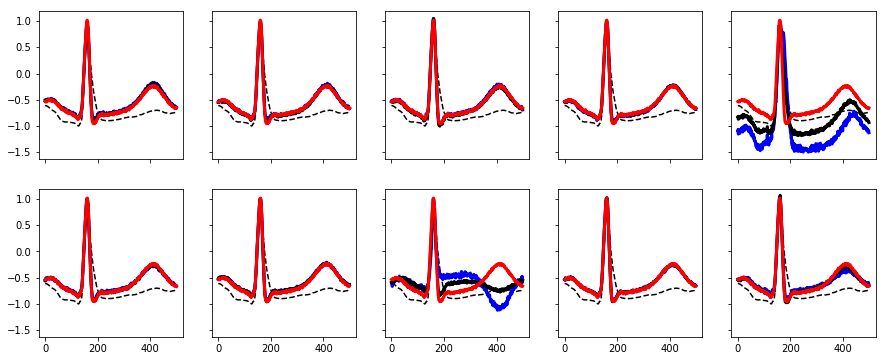

Epoch 10 | BCE 10.532624 | KL 4.795817 | C 5.0 | (KL-C) * beta 20.418310165405273 | Loss 30.950935


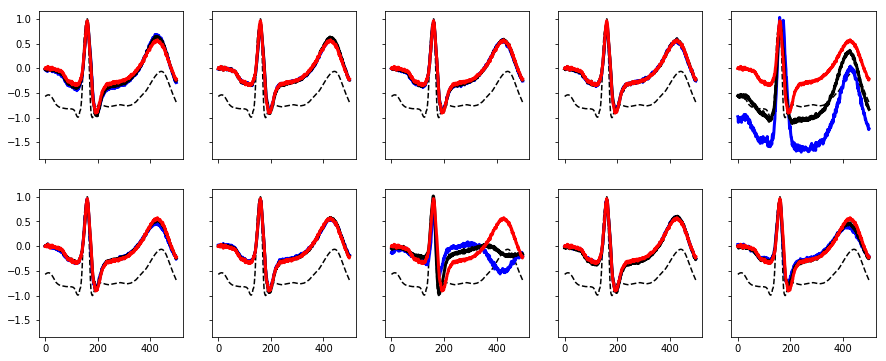

Epoch 11 | BCE 12.484677 | KL 5.3629365 | C 5.5 | (KL-C) * beta 13.706350326538086 | Loss 26.191029


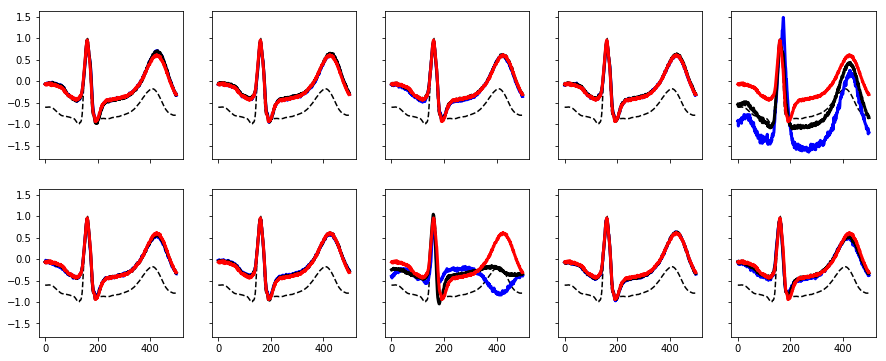

Epoch 12 | BCE 8.546773 | KL 6.094075 | C 6.0 | (KL-C) * beta 9.407520294189453 | Loss 17.954292


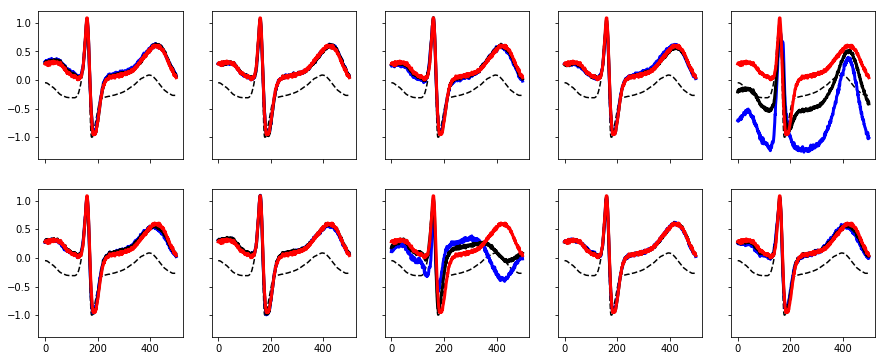

Epoch 13 | BCE 6.3231797 | KL 6.398874 | C 6.5 | (KL-C) * beta 10.112619400024414 | Loss 16.435799


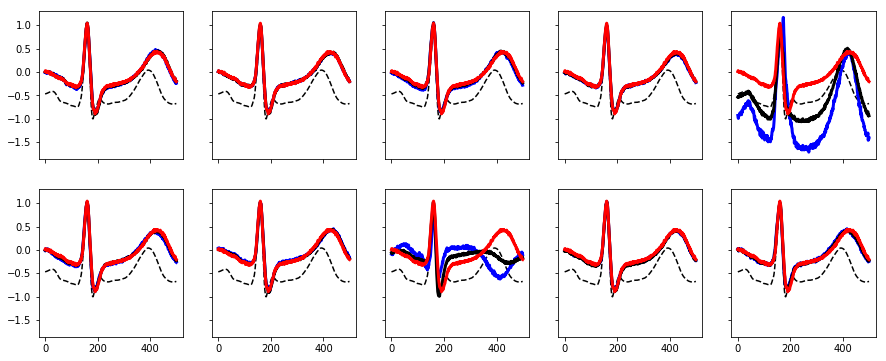

Epoch 14 | BCE 5.4126215 | KL 6.830595 | C 7.0 | (KL-C) * beta 16.94049835205078 | Loss 22.353119


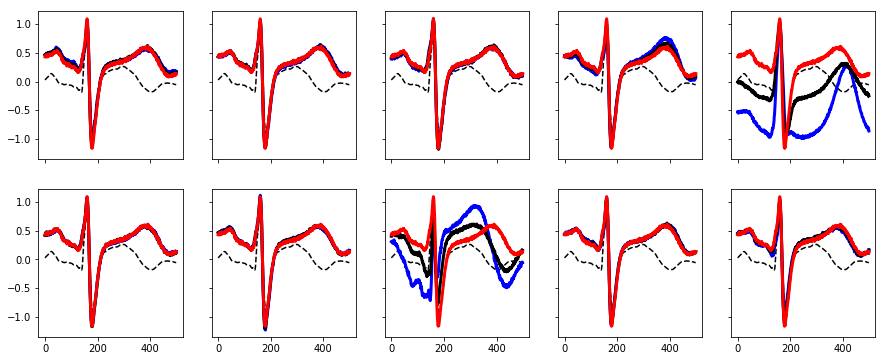

Epoch 15 | BCE 9.111081 | KL 7.5242786 | C 7.5 | (KL-C) * beta 2.4278640747070312 | Loss 11.538945


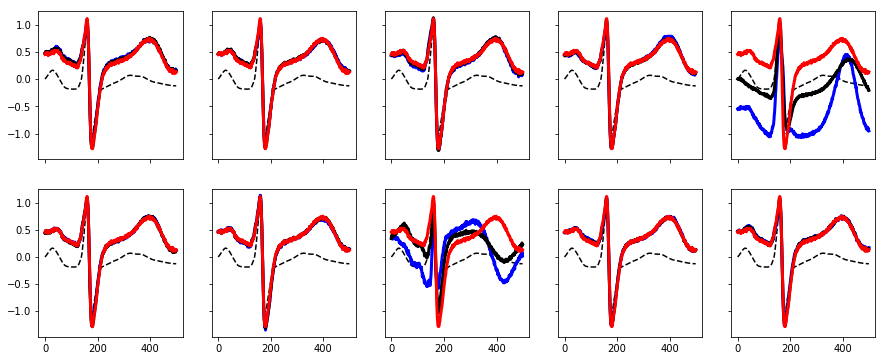

Epoch 16 | BCE 5.0920396 | KL 7.9877677 | C 8.0 | (KL-C) * beta 1.2232303619384766 | Loss 6.31527


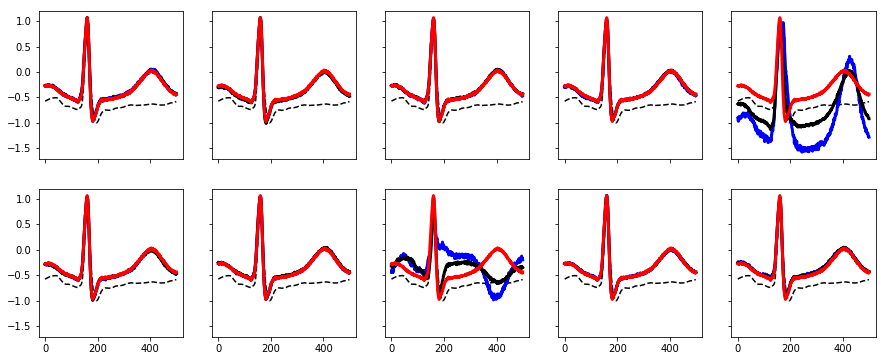

Epoch 17 | BCE 6.4271207 | KL 8.470369 | C 8.5 | (KL-C) * beta 2.9630661010742188 | Loss 9.390186


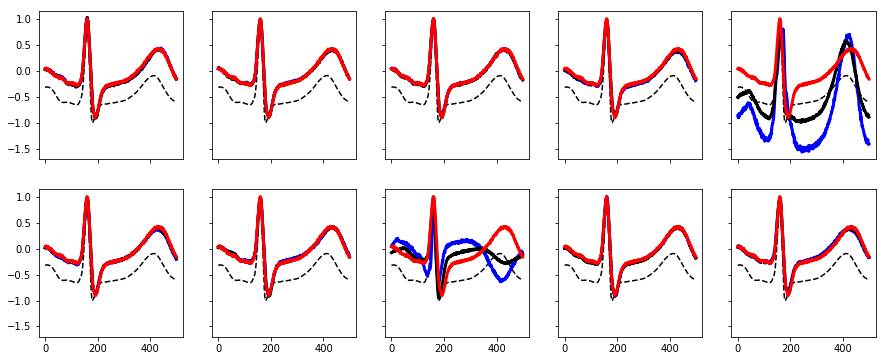

Epoch 18 | BCE 4.930504 | KL 9.300777 | C 9.0 | (KL-C) * beta 30.077743530273438 | Loss 35.008247


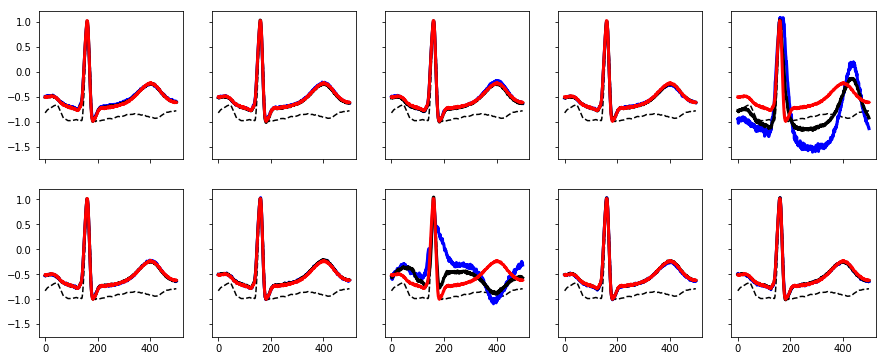

Epoch 19 | BCE 6.2613754 | KL 10.154438 | C 9.5 | (KL-C) * beta 65.44380187988281 | Loss 71.70518


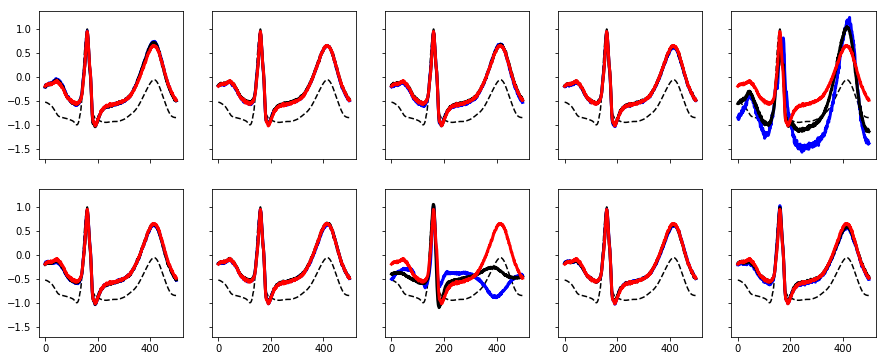

Epoch 20 | BCE 6.546137 | KL 10.197662 | C 10.0 | (KL-C) * beta 19.7662353515625 | Loss 26.312372


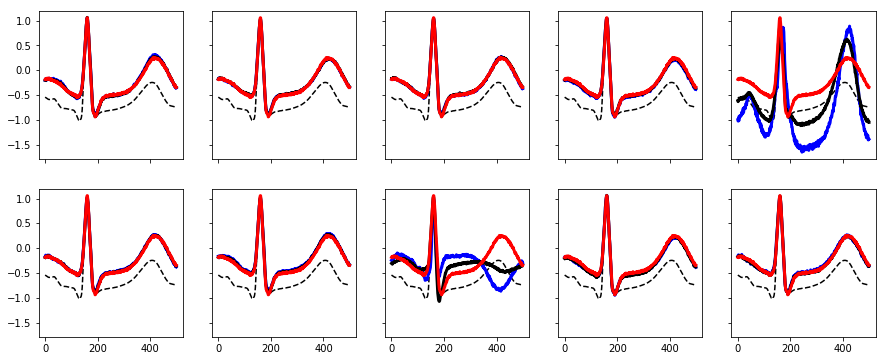

Epoch 21 | BCE 4.7805057 | KL 10.885697 | C 10.5 | (KL-C) * beta 38.56973648071289 | Loss 43.350243


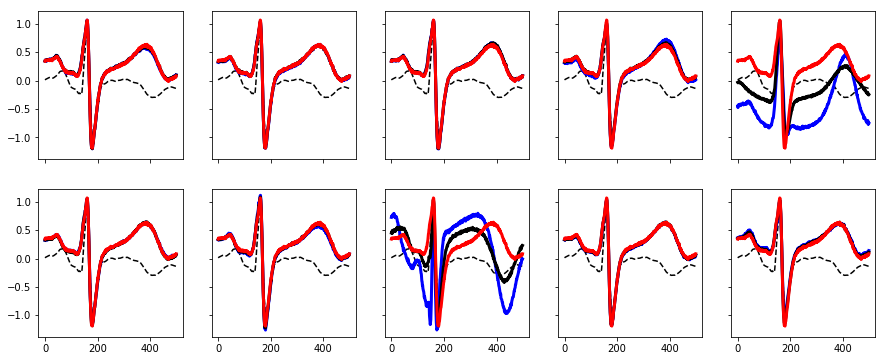

Epoch 22 | BCE 9.269978 | KL 11.428013 | C 11.0 | (KL-C) * beta 42.80128479003906 | Loss 52.071262


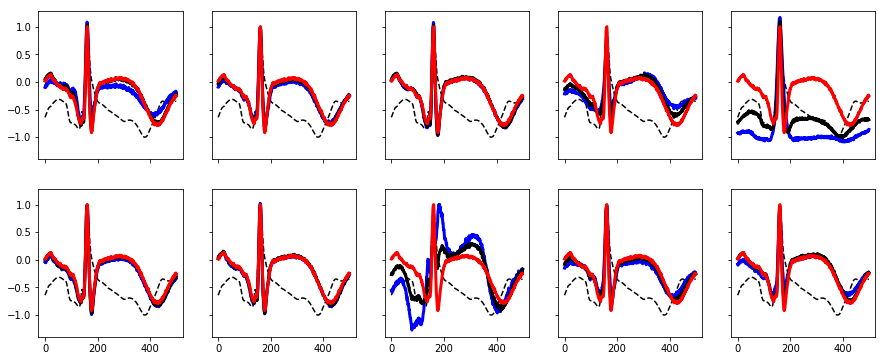

Epoch 23 | BCE 3.900949 | KL 11.394575 | C 11.5 | (KL-C) * beta 10.542488098144531 | Loss 14.443438


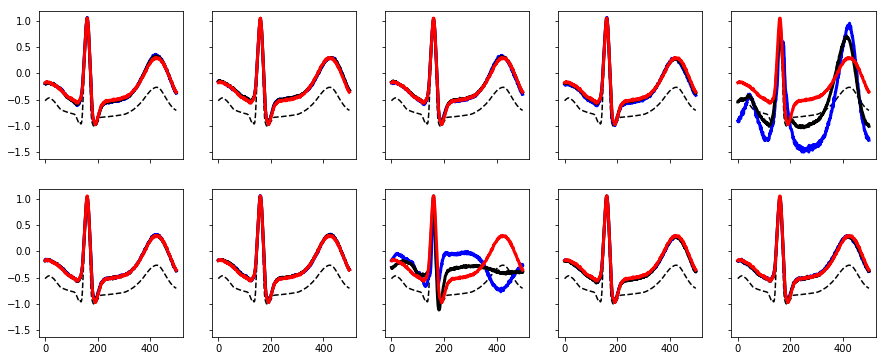

Epoch 24 | BCE 4.3800745 | KL 12.411204 | C 12.0 | (KL-C) * beta 41.12043380737305 | Loss 45.500507


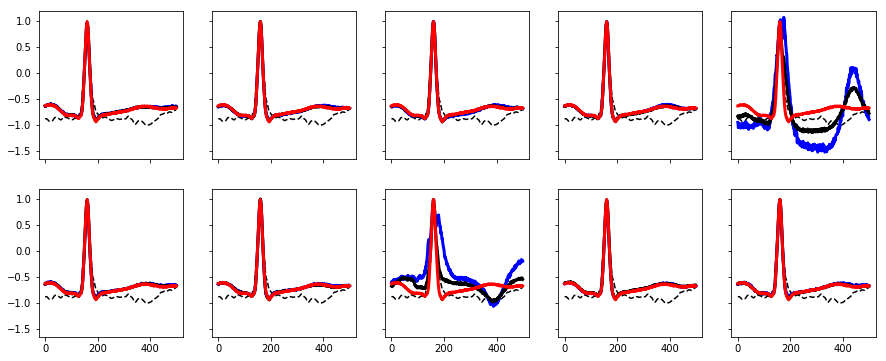

Epoch 25 | BCE 8.394141 | KL 11.675762 | C 12.5 | (KL-C) * beta 82.42378234863281 | Loss 90.817924


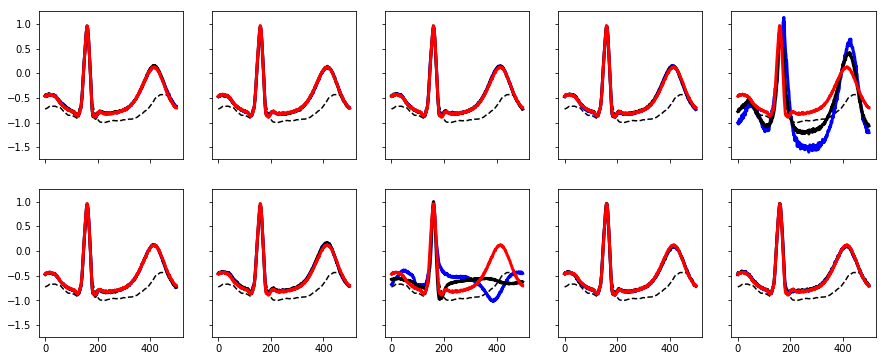

Epoch 26 | BCE 4.790076 | KL 12.864191 | C 13.0 | (KL-C) * beta 13.580894470214844 | Loss 18.37097


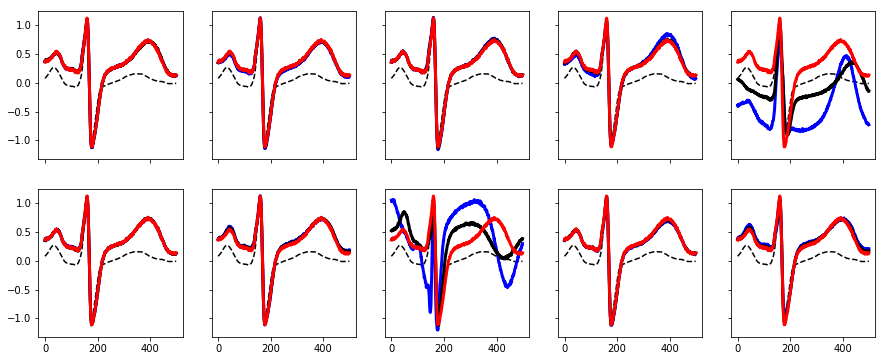

Epoch 27 | BCE 4.9341187 | KL 13.171824 | C 13.5 | (KL-C) * beta 32.81755447387695 | Loss 37.751675


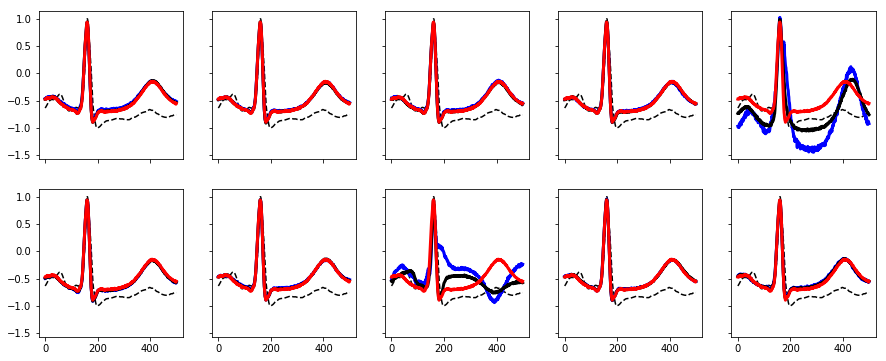

Epoch 28 | BCE 9.168063 | KL 13.803303 | C 14.0 | (KL-C) * beta 19.669723510742188 | Loss 28.837788


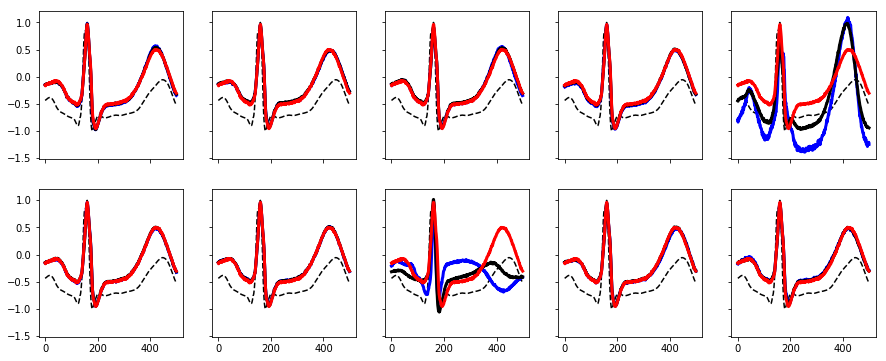

Epoch 29 | BCE 8.445099 | KL 14.239603 | C 14.5 | (KL-C) * beta 26.039695739746094 | Loss 34.484795


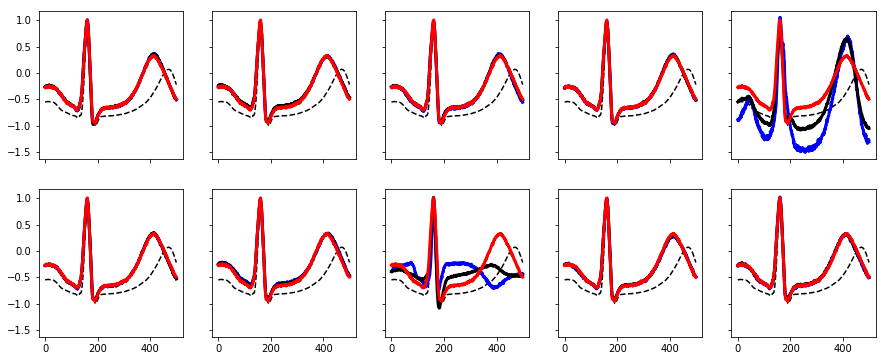

Epoch 30 | BCE 5.986096 | KL 14.409736 | C 15.0 | (KL-C) * beta 59.026432037353516 | Loss 65.01253


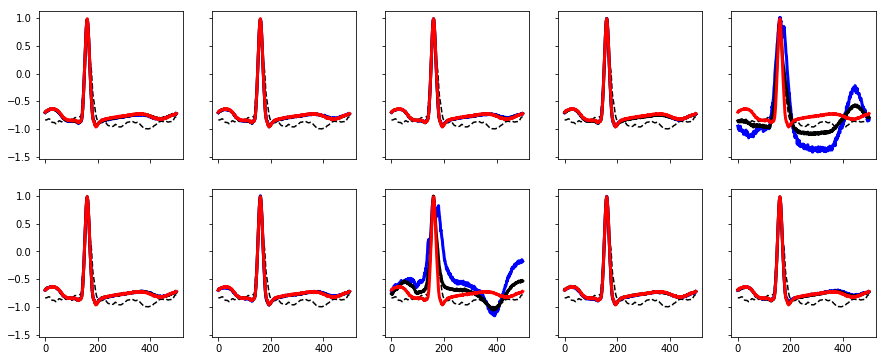

Epoch 31 | BCE 5.001697 | KL 14.866033 | C 15.5 | (KL-C) * beta 63.3967399597168 | Loss 68.39844


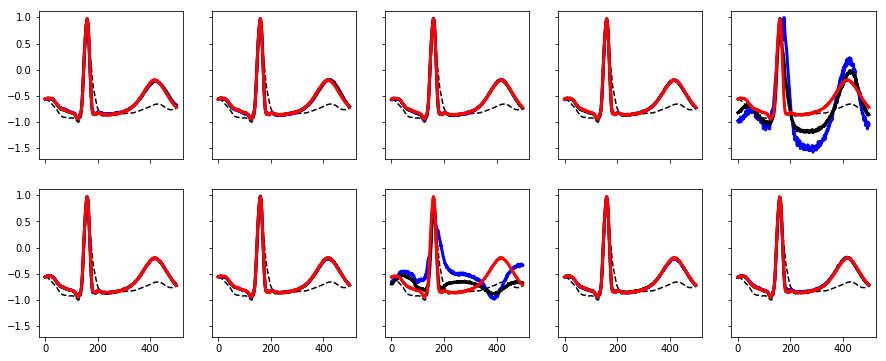

Epoch 32 | BCE 5.3004975 | KL 15.29974 | C 16.0 | (KL-C) * beta 70.02601623535156 | Loss 75.326515


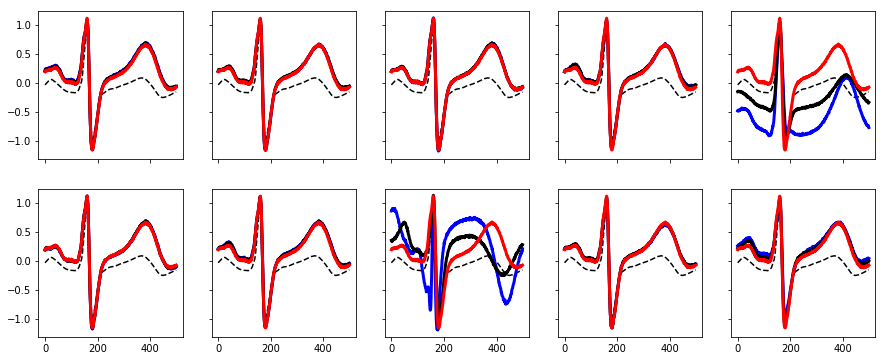

Epoch 33 | BCE 4.601786 | KL 16.88648 | C 16.5 | (KL-C) * beta 38.648033142089844 | Loss 43.24982


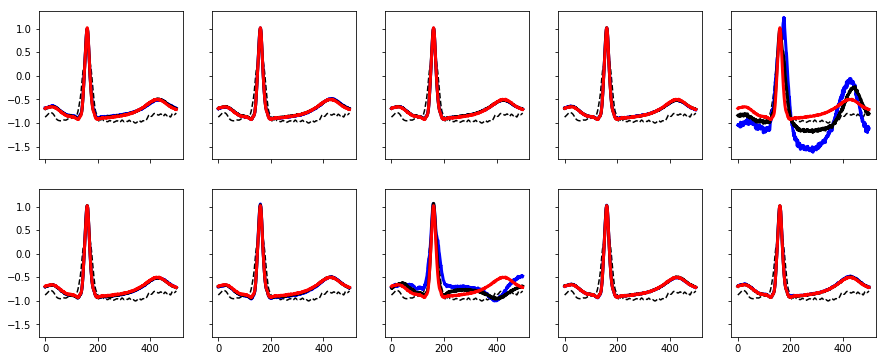

Epoch 34 | BCE 4.1681414 | KL 17.66131 | C 17.0 | (KL-C) * beta 66.13101959228516 | Loss 70.299164


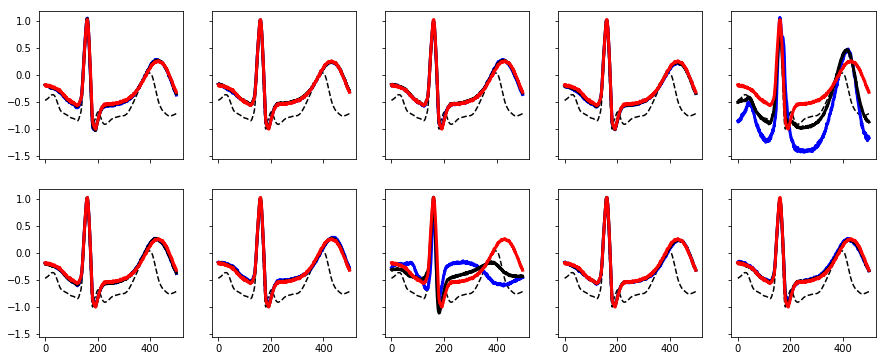

Epoch 35 | BCE 7.4902496 | KL 17.540798 | C 17.5 | (KL-C) * beta 4.0798187255859375 | Loss 11.570068


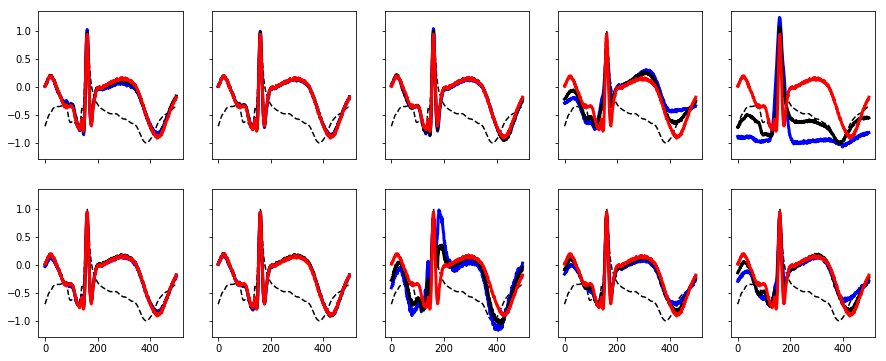

Epoch 36 | BCE 5.9195914 | KL 18.540983 | C 18.0 | (KL-C) * beta 54.09832000732422 | Loss 60.01791


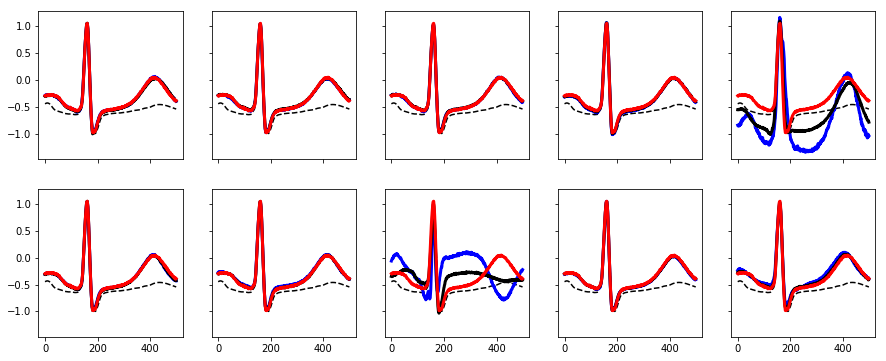

Epoch 37 | BCE 8.173321 | KL 18.052431 | C 18.5 | (KL-C) * beta 44.75688934326172 | Loss 52.93021


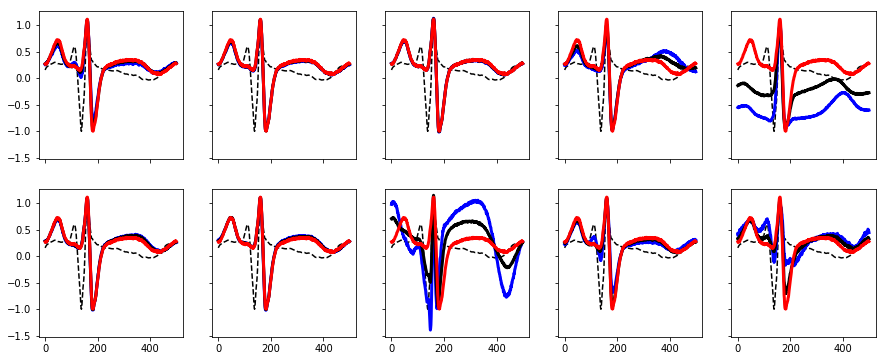

Epoch 38 | BCE 4.6625113 | KL 19.161816 | C 19.0 | (KL-C) * beta 16.181564331054688 | Loss 20.844076


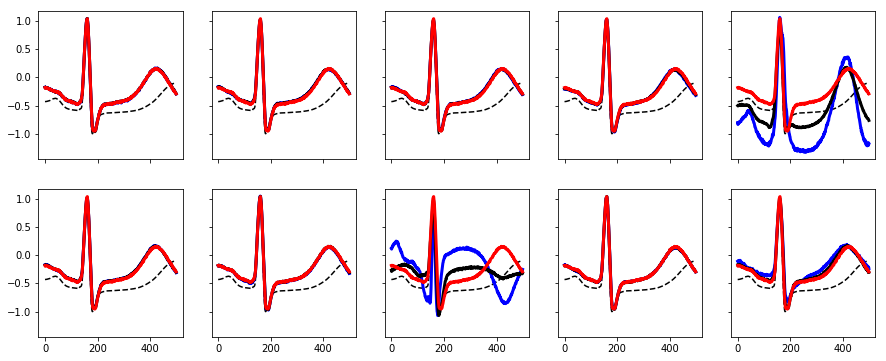

Epoch 39 | BCE 3.415421 | KL 19.192875 | C 19.5 | (KL-C) * beta 30.712509155273438 | Loss 34.12793


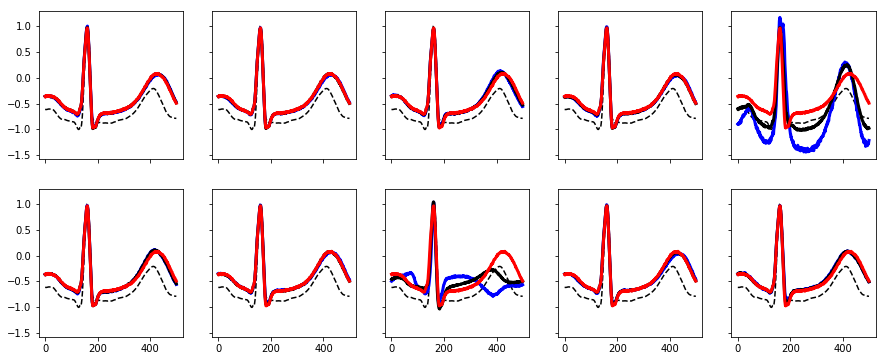

Epoch 40 | BCE 3.240442 | KL 20.391989 | C 20.0 | (KL-C) * beta 39.198875427246094 | Loss 42.439316


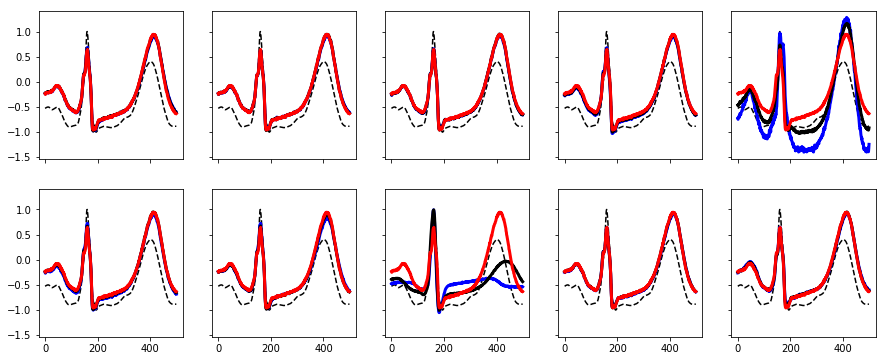

Epoch 41 | BCE 4.8479238 | KL 20.540466 | C 20.5 | (KL-C) * beta 4.046630859375 | Loss 8.894554


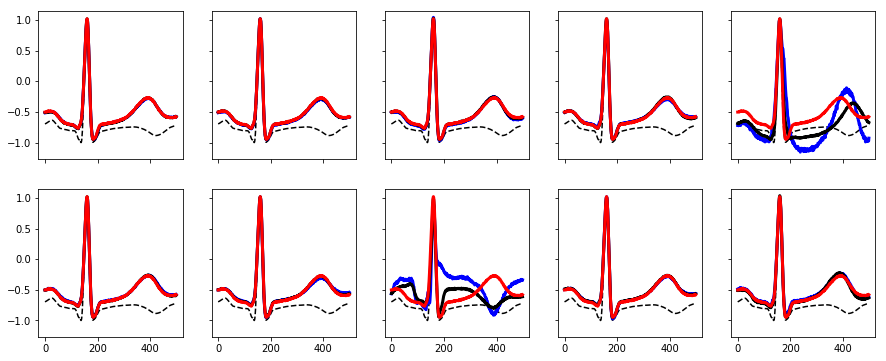

Epoch 42 | BCE 4.76454 | KL 21.169434 | C 21.0 | (KL-C) * beta 16.943359375 | Loss 21.7079


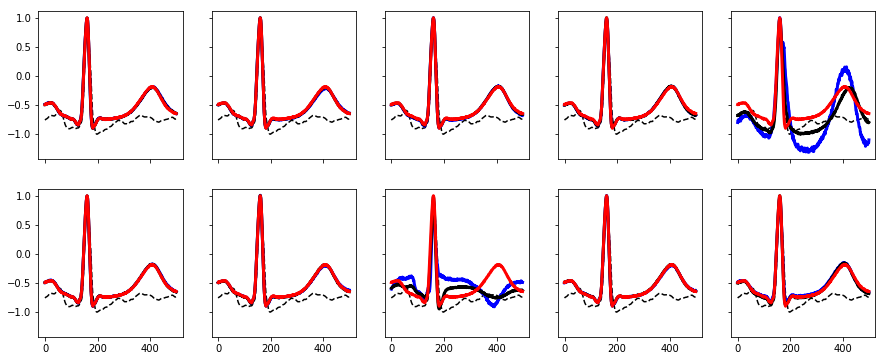

Epoch 43 | BCE 2.9229116 | KL 21.058704 | C 21.5 | (KL-C) * beta 44.12956237792969 | Loss 47.052475


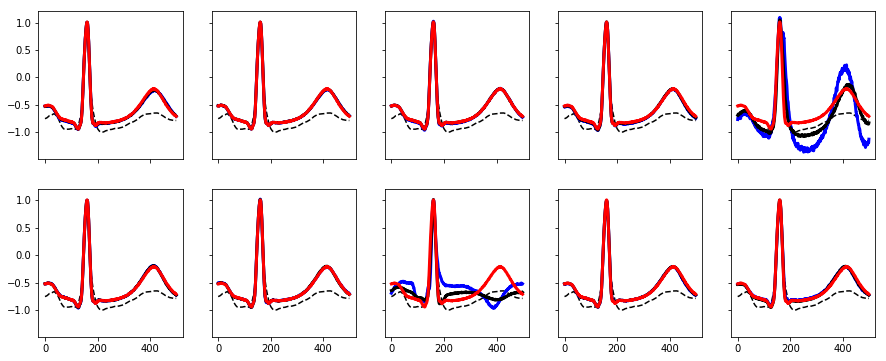

Epoch 44 | BCE 6.0164046 | KL 21.77635 | C 22.0 | (KL-C) * beta 22.36499786376953 | Loss 28.381403


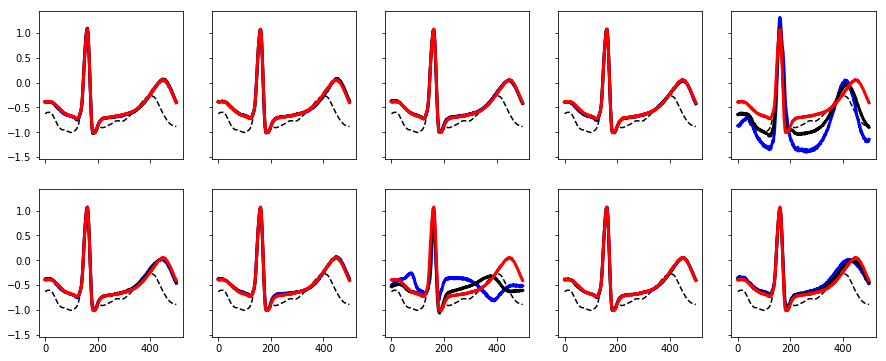

Epoch 45 | BCE 4.344527 | KL 22.927256 | C 22.5 | (KL-C) * beta 42.725563049316406 | Loss 47.07009


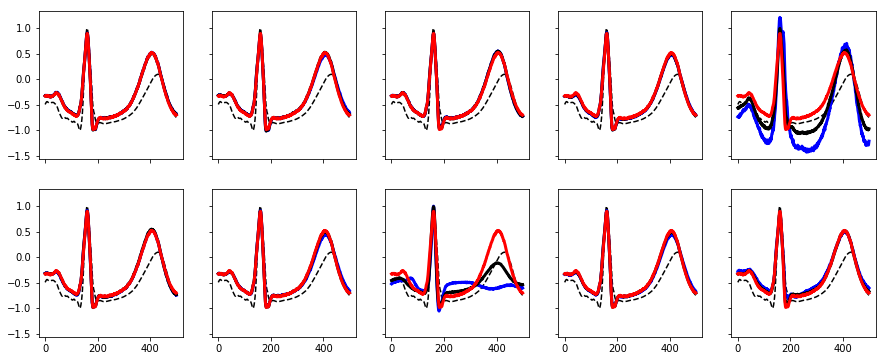

Epoch 46 | BCE 5.4919095 | KL 23.420689 | C 23.0 | (KL-C) * beta 42.06886291503906 | Loss 47.560772


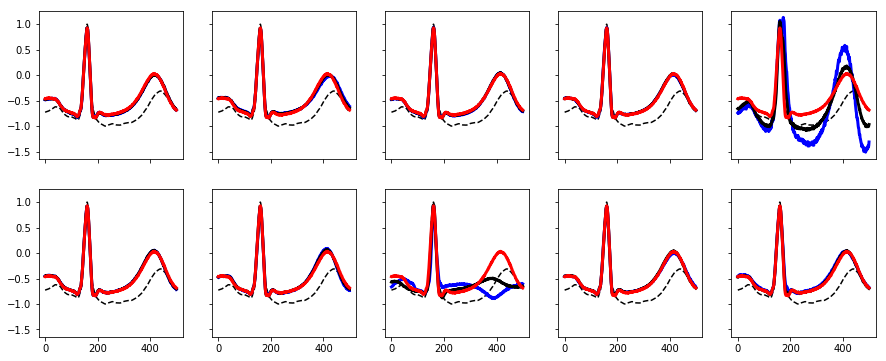

Epoch 47 | BCE 4.741833 | KL 23.892797 | C 23.5 | (KL-C) * beta 39.279747009277344 | Loss 44.02158


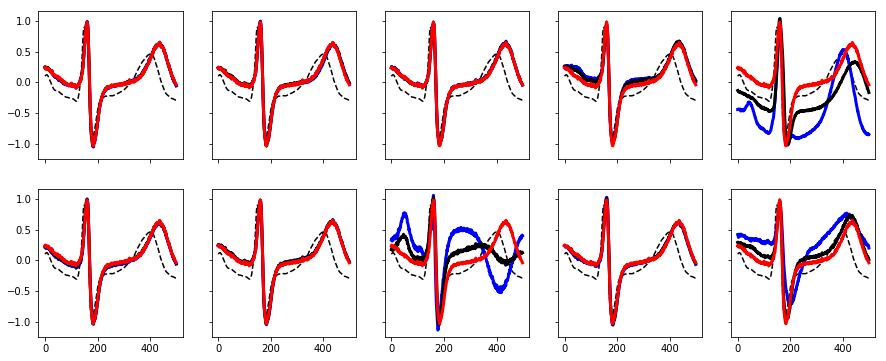

Epoch 48 | BCE 3.1708755 | KL 23.984297 | C 24.0 | (KL-C) * beta 1.5703201293945312 | Loss 4.7411957


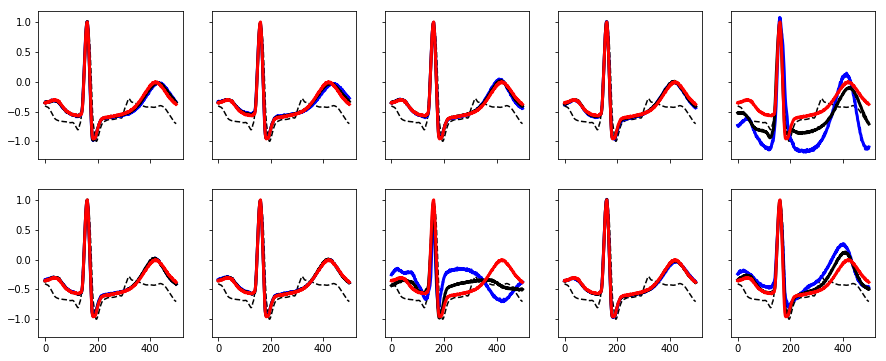

Epoch 49 | BCE 4.7035956 | KL 24.170887 | C 24.5 | (KL-C) * beta 32.91130065917969 | Loss 37.614895


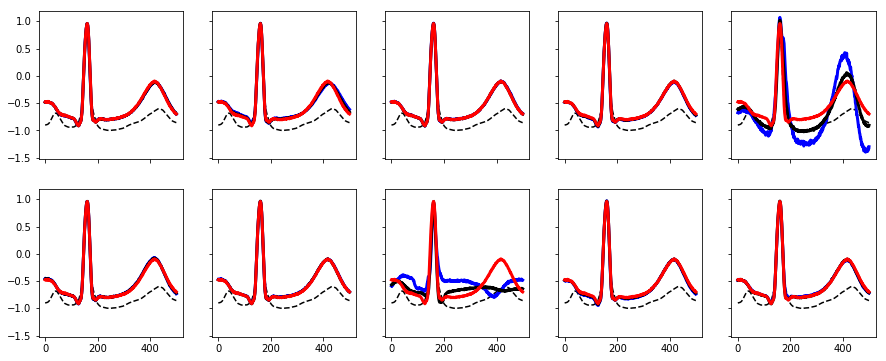

In [16]:
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        try:
            BCE, KLD = loss_function(recon_batch, data, mu, logvar)
            BCE, KLD = BCE / len(data), KLD / len(data)
            
            loss = BCE + beta * torch.abs(KLD - C)
            
            loss.backward()
            optimizer.step()
        except:
            continue
            
        if epoch > C_stop:
            C = C_final

#     if epoch % 10 == 0:                
    print('Epoch', str(epoch), 
          '| BCE', BCE.data.numpy(), 
          '| KL', KLD.data.numpy(), 
          '| C', C, 
          '| (KL-C) * beta', torch.abs(KLD - C).data.numpy() * beta, 
          '| Loss', loss.data.numpy())

    visualize(model, latent_dim, np.arange(-3, 3.5, 1.5))

    C += C_delta

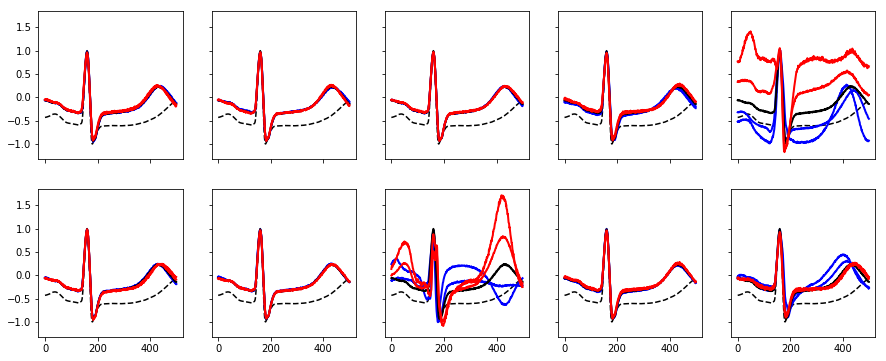

In [55]:
viz = []

random_index = np.random.randint(len(X)-1)
X_random = X[random_index]
zi, zi_std = model.encode(torch.Tensor(X_random))
# zi = torch.randn(latent_dim)
for j in range(latent_dim):    
    buf = []   
    for i in np.arange(-3, 4, 1.5):
        x = zi.clone()
        x[j] += i
        zi2 = torch.zeros(latent_dim)
        gen_imgs = model.decode(model.reparameterize_static(x, zi2))
        gen_imgs_np = gen_imgs.data.numpy()
        buf.append(gen_imgs_np)
    viz.append(buf)

N, M = 5, int(latent_dim / 5)
fig, axs = plt.subplots(M, N, sharex=True, sharey=True, figsize=(int(N*3), int(M*3)))

k = 0
for i in range(M):
    for j in range(N):
        axs[i, j].plot(X_random, ls = '--', color = 'black')
        
        ts = np.array(viz[k]).T
        axs[i, j].plot(ts[:, 0], lw = 2, color = 'blue')
        axs[i, j].plot(ts[:, 1], lw = 2, color = 'blue')
        axs[i, j].plot(ts[:, 2], lw = 2, color = 'black')
        axs[i, j].plot(ts[:, 3], lw = 2, color = 'red')
        axs[i, j].plot(ts[:, 4], lw = 2, color = 'red')
        k += 1
plt.show()